# Stage 5: Speed of the CME

A very important part of our Solar System is the Sun itself. It is for this reason that we, as its residents, have many observatories, both ground and space-based, that take measurements related to it and its influence.



1.   Calculate the speed of the CME using observations.

In [3]:
t1 = input('Enter the time plasma structure erupted on the Sun')
t2 = input('Enter the time plasma structure erupted is spotted in the coronagraph')



Enter the time plasma structure erupted on the Sun 1
Enter the time plasma structure erupted is spotted in the coronagraph 1


As we have just seen, it is fairly straightforward to get images from a spacecraft into Python and show them, but what can we do once we have these images?

## How far has the CME travelled?

A key reason for us to observe the Sun is for predicting space weather. We need to know when a CME is hitting the Earth.

In [1]:
import glob
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

map_list = []
map_list = sorted(glob.glob('LASCO_images/*.png'))


In [2]:
print(len(map_list))

82


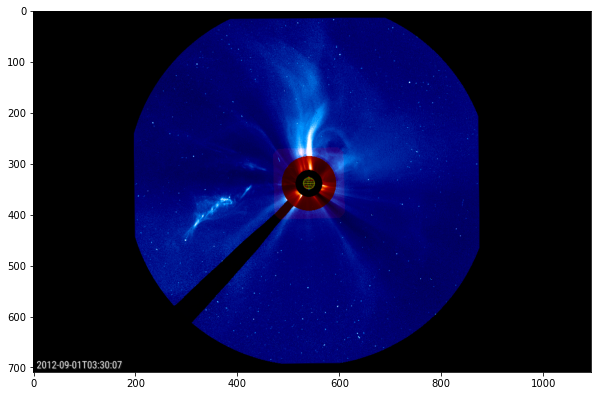

In [29]:
import numpy as np

filename = map_list[40]
img = cv2.imread(filename)
height, width, layers = img.shape

fig=plt.figure(figsize=(10, 10))
imgplot = plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [ ]:
from PIL import Image, ImageOps

im = Image.open('data/src/lena.jpg')
im_invert = ImageOps.invert(im)

In [12]:
print(img[0][0])

[0 0 0]


## How soon does it hit the Earth

A key reason for us to observe the Sun is for predicting space weather. We need to know when a CME is hitting the Earth.

1.   Use the speed calculated to deduce the time plasma structures hit Earth.

In [11]:
import cv2  # Here, we import OpenCV, a powerful image and video processing tool
from os import getcwd


img_array = []

for filename in sorted(glob.glob(f'{dir_png}/*.png')):
  img = cv2.imread(filename)
  height, width, layers = img.shape
  size = (width,height)
  img_array.append(img)

out = cv2.VideoWriter('solar_vid.avi',cv2.VideoWriter_fourcc(*'DIVX'), 3, size)
 
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()


With the above, we will have created a movie called "solar_vid.mp4", which holds all of our images together.